<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/01_06_define_ignore_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Tree Crown Ignore Region Definition and Merging Pipeline

A geospatial workflow that filters automatically detected tree crowns based on 
cadastral mask regions, creates ignore classes for training data, and merges 
cadaster-validated crowns with detected crowns.

Overview:
    Processes cleaned tree crown GeoJSON files and applies spatial filtering using
    cadastral boundaries. Removes crowns intersecting cadaster masks, simplifies
    geometries, and merges results with cadaster-only crowns for training datasets.

Main Sections:

    1. Configuration - Set paths and parameters (simplification tolerance: 0.5m)
    
    2. Filtering Methods:
       - Approach A: Filter by 'intersects_cadaster' attribute (!= 1)
       - Approach B: Remove crowns intersecting cadaster mask union
    
    3. Geometry Processing - Simplify (0.5m tolerance) and buffer (1m) crowns
    
    4. Crown Merging - Combine processed and cadaster-only crowns with class labels
    
    5. Validation & Visualization - Plot on DOP raster with classification

Key Data:

    Input:
    - Cleaned crown GeoJSON files (per tile)
    - Cadastral mask (GPKG with buffer polygons)
    - Sliced DOP imagery (100m x 100m tiles)
    
    Output:
    - Filtered crowns (ignore regions)
    - Merged crowns with 'intersects_cadaster' flag (0 or 1)

CRS: EPSG:25833 (UTM Zone 33N) - Berlin/Germany region

Processing Parameters:

    - Simplification tolerance: 0.5 meters
    - Buffer distance: 1 meter
    - Class label: intersects_cadaster (1=cadaster, 0=detected/ignore)

Output Locations:

    - {aoi_code}/crowns_veg_mask_with_ignore_region/ - Filtered crowns
    - {aoi_code}/crowns_with_ignore_region/ - Mask-filtered crowns
    - {aoi_code}/crowns_merged/ - Final merged dataset

Key Features:

    - Two filtering approaches (attribute and mask-based)
    - Fast spatial filtering using unary union
    - Geometry simplification with topology preservation
    - Flexible crown source merging
    - Visualization support for validation
    - Robust handling of missing directories

Workflow:

    1. Load cleaned crowns and filter by cadastral intersection
    2. Simplify geometries and apply 1m buffer
    3. Load cadaster-only crowns (if available) and tag with flag
    4. Merge processed + cadaster crowns
    5. Visualize on DOP raster with color-coded classes

Classification:
    - intersects_cadaster = 1: Official cadastral records (validated)
    - intersects_cadaster = 0: Detected crowns (potential false positives, ignore class)
"""

# --- Setup ---

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show as rioshow
import pandas as pd

# --- Configuration ---

In [ ]:
aoi_code = '386_5818' # training data
#aoi_code = '384_5816' # test data

base_path = '/content/drive/MyDrive/masterthesis/data'

input_dir = f'{base_path}/{aoi_code}/crowns_clean'
raster_dir= f'{base_path}/{aoi_code}/sliced_imgs_2020S'
trees_dir = f'{base_path}/{aoi_code}/cadaster_points'
output_dir = f'{base_path}/{aoi_code}/crowns_veg_mask_with_ignore_region'
os.makedirs(output_dir, exist_ok=True)

simplify_tolerance = 0.5

# --- Processing ---

In [ ]:
for fname in os.listdir(input_dir):
    if not fname.lower().endswith('.geojson'):
        continue
    in_path  = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)

    gdf = gpd.read_file(in_path)

    # Filter and create a true copy
    if 'intersects_cadaster' in gdf.columns:
        gdf = gdf.loc[gdf['intersects_cadaster'] != 1].copy()

    simplified = gdf.geometry.simplify(simplify_tolerance, preserve_topology=True)
    buffered   = simplified.buffer(1)
    gdf.loc[:, 'geometry'] = buffered

    gdf.to_file(out_path, driver='GeoJSON')

# --- Test ---

<ipython-input-6-7c4fa101447c>:41: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
<ipython-input-6-7c4fa101447c>:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


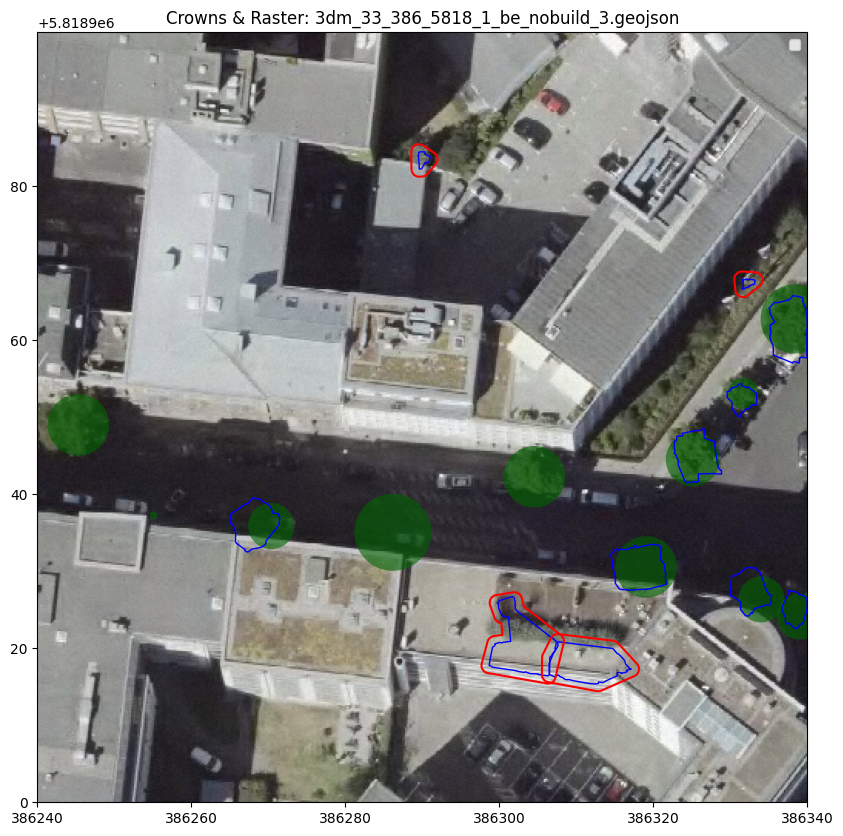

In [ ]:
# Plot original crowns, processed crowns, and corresponding raster for a single example
example_files = [f for f in os.listdir(output_dir) if f.lower().endswith('.geojson')]
if not example_files:
    print("No processed files found in output directory.")
else:
    # fname = example_files[4]
    fname = '3dm_33_386_5818_1_be_nobuild_3.geojson'
    base = os.path.splitext(fname)[0]
    tree_path = os.path.join(trees_dir, fname)
    tree_gdf = gpd.read_file(tree_path)


    not_in_cadaster_df = gpd.read_file(os.path.join(output_dir, fname))
    original_gdf  = gpd.read_file(os.path.join(input_dir, fname))
    raster_path = os.path.join(raster_dir, base + '.tif')

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot raster background
    if os.path.exists(raster_path):
        with rasterio.open(raster_path) as src:
            rioshow(src, ax=ax)
    else:
        print(f"Raster not found at {raster_path}")

    tree_gdf.plot(ax=ax, color='darkgreen', alpha=0.6, markersize=8, label='Tree Points')

    # Plot original crowns in blue
    original_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1, label='Original Crowns')
    # Plot processed crowns in red
    not_in_cadaster_df.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1.5, label='Processed Crowns')

    ax.set_title(f"Crowns & Raster: {fname}")
    ax.legend()
    plt.show()



# --- Processing ---

In [ ]:
# Define cadaster-only and merged output directories
merged_dir        = '/content/drive/MyDrive/masterthesis/data/386_5818/crowns_merged'
cadaster_only_dir = '/content/drive/MyDrive/masterthesis/data/386_5818/crowns_clean_cadaster_only'

os.makedirs(merged_dir, exist_ok=True)

processed_dir = output_dir  # '/content/drive/.../crowns_with_ignore_region'

# Loop through each processed GeoJSON
for fname in os.listdir(processed_dir):
    if not fname.lower().endswith('.geojson'):
        continue

    proc_fp = os.path.join(processed_dir, fname)
    cad_fp  = os.path.join(cadaster_only_dir, fname)

    # Load the processed crowns (intersects_cadaster ≠ 1)
    proc_gdf = gpd.read_file(proc_fp)

    # Load cadaster-only crowns & tag them, or create an empty slice
    if os.path.exists(cad_fp):
        cad_gdf = gpd.read_file(cad_fp)
        cad_gdf['intersects_cadaster'] = 1
    else:
        cad_gdf = gpd.GeoDataFrame(
            columns=proc_gdf.columns,
            geometry='geometry',
            crs=proc_gdf.crs
        )

    # 4) Concatenate and re-wrap as a GeoDataFrame
    merged_df  = pd.concat([proc_gdf, cad_gdf], ignore_index=True)
    merged_gdf = gpd.GeoDataFrame(merged_df, crs=proc_gdf.crs)

    # 5) Write out the merged file
    merged_gdf.to_file(
        os.path.join(merged_dir, fname),
        driver='GeoJSON'
    )

print(f"All crowns merged and saved to: {merged_dir}")

print(f"All crowns merged and written to: {merged_dir}")


✅ All crowns merged and saved to: /content/drive/MyDrive/masterthesis/data/386_5818/crowns_merged
✅ All crowns merged and written to: /content/drive/MyDrive/masterthesis/data/386_5818/crowns_merged


# --- Visualisation ---

In [ ]:
# Load the corresponding raster
base = os.path.splitext(fname)[0]
raster_fp = os.path.join(raster_dir, base + '.tif')

# Split into cadaster / non-cadaster
cad = merged_gdf[merged_gdf['intersects_cadaster'] == 1]
no_cad = merged_gdf[merged_gdf['intersects_cadaster'] != 1]

fig, ax = plt.subplots(figsize=(10, 10))

with rasterio.open(raster_fp) as src:
    rioshow(src, ax=ax)

cad.plot(ax=ax,
         facecolor='none',
         edgecolor='green',
         label='intersects_cadaster = 1')

no_cad.plot(ax=ax,
            facecolor='red',
            edgecolor='none',
            alpha=0.3,
            label='intersects_cadaster ≠ 1')

ax.set_title(f"Merged Crowns ({fname})")
ax.legend()
plt.show()